
**following processes on :**
https://github.com/KavehVasei/Capstone2-UK-Road-Safty/blob/main/Models_acc_veh.ipynb
**we look for other models and make them less complicated to prevent overfitting**


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
import missingno as msno
import matplotlib.dates as mdates
import pickle
import datetime


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, roc_auc_score, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             make_scorer)


!pip install scikit-plot
import scikitplot as skplt


In [1]:
# connecting to colab
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive
!ls "/content/drive/MyDrive/Colab Notebooks/Data/"
Data_Folder_Name="/content/drive/My Drive/"

Mounted at /content/drive
 Accidents   BookRecommender    Personal
 Astro	    'Colab Notebooks'   topcat-full.jar
dft-road-casualty-statistics-accident-2020.csv
dft-road-casualty-statistics-casualty-2020.csv
dft-road-casualty-statistics-vehicle-2020.csv
Road-Safety-Open-Dataset-Data-Guide.xlsx


In [29]:
### The full dataset was prepared in Data Reduction.ipynb at: https://github.com/KavehVasei/Capstone2-UK-Road-Safty/blob/main/DataReduction.ipynb
df_cat = pd.read_pickle("./drive/MyDrive/Accidents/Data/acc_veh_cat.pkl")
### classify cols characteristics

# to be dropped for ML
outofX=['accident_severity','day_of_week','hour','accident_level']

#numerical Features
numcols=['accident_year','longitude','latitude','speed_limit']

#Categorical:     binary columns
binarycols=['urban_or_rural_area','did_police_officer_attend_scene_of_accident','weekend','covid']

#Categorical:     Ordinal Columns  # treat like numerics
ordinals=['number_of_vehicles','number_of_casualties','smallest_veh','biggest_vel','towing','restricted',
          'skidding','jacknifed','overturned','xcenterguard','rebounded','male_drivers','female_drivers']


#Categorical:     Nominal Columns
nominals=['police_force','first_road_class','road_type','junction_detail','pedestrian_crossing_human_control',
          'pedestrian_crossing_physical_facilities','light_conditions','weather_conditions','road_surface_conditions',
          'special_conditions_at_site','carriageway_hazards','trunk_road_flag','month','time_of_day','junction_location']

df_cat[nominals] = df_cat[nominals].astype('category')

df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278143 entries, 2 to 308585
Data columns (total 40 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   accident_year                                278143 non-null  int32   
 1   longitude                                    278143 non-null  float64 
 2   latitude                                     278143 non-null  float64 
 3   police_force                                 278143 non-null  category
 4   accident_severity                            278143 non-null  uint8   
 5   number_of_vehicles                           278143 non-null  uint8   
 6   number_of_casualties                         278143 non-null  uint8   
 7   day_of_week                                  278143 non-null  uint8   
 8   first_road_class                             278143 non-null  category
 9   road_type                                    278

In [30]:
# Perform one-hot encoding on the nominal columns
df_encoded = pd.get_dummies(df_cat[nominals])

# Concatenate the encoded columns with the remaining columns
df_encoded = pd.concat([df_cat.drop(nominals, axis=1), df_encoded], axis=1)
df_encoded.head(3)

,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,speed_limit,urban_or_rural_area,did_police_officer_attend_scene_of_accident,...,time_of_day_4,junction_location_0,junction_location_1,junction_location_2,junction_location_3,junction_location_4,junction_location_5,junction_location_6,junction_location_7,junction_location_8
2,2019,-0.124193,51.526795,3,2,1,3,30,1,1,...,1,0,1,0,0,0,0,0,0,0
3,2019,-0.191044,51.546387,2,1,1,3,20,1,1,...,1,0,0,1,0,0,0,0,0,0
4,2019,-0.200064,51.541121,3,2,2,3,30,1,1,...,1,0,0,1,0,0,0,0,0,0


### Train Vlidation and test sets

In [5]:
Xc = df_cat.drop(outofX, axis=1) #['accident_level','accident_severity']
yc = df_cat['accident_level']

# Split the data into train and test sets
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.15, stratify=yc, random_state=82)

# Further split the train set into train and validation sets
Xc_train, Xc_val, yc_train, yc_val = train_test_split(Xc_train, yc_train, test_size=0.15, stratify=yc_train, random_state=82)


print( f"Shapes of the datasets with multi label categories: \n")
print("Train set shape:", Xc_train.shape, yc_train.shape)
print("Validation set shape:", Xc_val.shape, yc_val.shape)
print("Test set shape:", Xc_test.shape, yc_test.shape)



Xe = df_encoded.drop(['accident_level','accident_severity'], axis=1)
ye = df_encoded['accident_level']

# Split the data into train and test sets
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.15, stratify=ye, random_state=82)

# Further split the train set into train and validation sets
Xe_train, Xe_val, ye_train, ye_val = train_test_split(Xe_train, ye_train, test_size=0.15, stratify=ye_train, random_state=82)


print( f"\n\n Shapes of the Encoded datasets: \n")
print("Train set shape:", Xe_train.shape, ye_train.shape)
print("Validation set shape:", Xe_val.shape, ye_val.shape)
print("Test set shape:", Xe_test.shape, ye_test.shape)


Shapes of the datasets with multi label categories: 

Train set shape: (200957, 36) (200957,)
Validation set shape: (35464, 36) (35464,)
Test set shape: (41722, 36) (41722,)


 Shapes of the Encoded datasets: 

Train set shape: (200957, 172) (200957,)
Validation set shape: (35464, 172) (35464,)
Test set shape: (41722, 172) (41722,)


In [31]:
# Here is functions to evaluate each model:
def evaluate_classifier(model, X_test, y_test,index = ['Actual Minor_Acc', 'Actual Major_Acc' ]):

    """
    Takes a model and its test data.
    Prints and returns model metrics.
    """

    # get predictions
    y_pred = model.predict(X_test)

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # compute Area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot ROC curve
    title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(fpr, tpr)
    _ = plt.plot([0,1], [0,1], 'k--')
    _ = plt.xlabel('False Positive Rate (FPR)')
    _ = plt.ylabel('True Positive Rate (TPR)')
    _ = plt.title(title)
    _ = plt.legend(['predictive power','random vector'])
    # show plot when function is called, plot not returned
    plt.show()


    # construct confusion matrix
    #conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
    #conf_matrx.columns = ['Predict: NO', 'Predict: YES']
    #conf_matrx.index = ['Actual: NO', 'Actual: YES']

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = index,
                           columns = [f'predicted \n Minor', f'predicted \n Major'])

    conf_matrix

    # get classification report
    report = classification_report(y_test, y_pred)
    print(report)
    return conf_matrix, report


# Here is a function to perform a quick evaluation of each model:
def ROC_PRC(model, X_test, y_test,index = ['Actual Minor_Acc', 'Actual Major_ACC' ]):

    y_pred_prob = model.predict_proba(X_test)

    #plot roc curve and  print AUC score
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    skplt.metrics.plot_roc(y_test, y_pred_prob, ax=axes[0])
    axes[0].set_title('ROC Curve - Categorical Version')
    skplt.metrics.plot_precision_recall(y_test, y_pred_prob, ax=axes[1])
    axes[1].set_title('Precision-Recall Curve  - Categorical Version')
    plt.tight_layout()
    plt.show()
    auc_score = roc_auc_score(y_test, y_pred_prob[:,1])
    auprc_score = average_precision_score(y_test, y_pred_prob[:, 1])
    print('AUC score:  {}         AUPRC score:  {}'.format(auc_score,auprc_score))

    return auc_score, auprc_score



### Dataset Imbalance Strategies:

**Here I check three ways to handle imbalance:**

**1- undersampling**

**2-oversampling Using SMOTE**

**3-using balance weights in various models that accept categorical data : (feading Xc or Xe directly)**

In [6]:
stop

## **Random Forest Classifier with balanced weights BFR_CLF trial 1:**  


It takes 4777.575 seconds for tuning

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = { 'n_estimators': [300,500],
                  'criterion': ["gini"],
                  'max_depth': [15,20],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [3,5]}

BEST PARAMS {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}


In [8]:
from imblearn.ensemble import BalancedRandomForestClassifier

#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train
y_train=yc_train
X_test=Xc_val
y_test=yc_val

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label=1)
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [300,500],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [15,20],#50],# 12],
    'max_features': ['sqrt'],#'log2']
    'min_samples_leaf': [3,5]

}
rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='f1_score')  #using f1

#rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


It takes 4777.575 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}
Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 300}
   f1_score: 0.464 (+/-0.003)
   precision: 0.382 (+/-0.002)
   recall: 0.591 (+/-0.005)
   accuracy: 0.687 (+/-0.001)
   auc: 0.653 (+/-0.003)
   auprc: 0.320 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 500}
   f1_score: 0.463 (+/-0.003)
   precision: 0.382 (+/-0.002)
   recall: 0.589 (+/-0.004)
   accuracy: 0.686 (+/-0.001)
   auc: 0.652 (+/-0.002)
   auprc: 0.319 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}
   f1_score: 0.467 (+/-0.003)
   precision: 0.379 (+/-0.002)
   recall: 0.608 (+/-0.006)
   accuracy: 0.681 (+/-0.001)
   auc: 0.

It takes 4777.575 seconds for tuning
BEST PARAMS {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}
Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 300}
   f1_score: 0.464 (+/-0.003)
   precision: 0.382 (+/-0.002)
   recall: 0.591 (+/-0.005)
   accuracy: 0.687 (+/-0.001)
   auc: 0.653 (+/-0.003)
   auprc: 0.320 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 500}
   f1_score: 0.463 (+/-0.003)
   precision: 0.382 (+/-0.002)
   recall: 0.589 (+/-0.004)
   accuracy: 0.686 (+/-0.001)
   auc: 0.652 (+/-0.002)
   auprc: 0.319 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}
   f1_score: 0.467 (+/-0.003)
   precision: 0.379 (+/-0.002)
   recall: 0.608 (+/-0.006)
   accuracy: 0.681 (+/-0.001)
   auc: 0.656 (+/-0.003)
   auprc: 0.321 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 500}
   f1_score: 0.467 (+/-0.004)
   precision: 0.379 (+/-0.003)
   recall: 0.607 (+/-0.006)
   accuracy: 0.681 (+/-0.002)
   auc: 0.655 (+/-0.003)
   auprc: 0.321 (+/-0.003)
Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 300}
   f1_score: 0.439 (+/-0.004)
   precision: 0.412 (+/-0.004)
   recall: 0.469 (+/-0.005)
   accuracy: 0.724 (+/-0.002)
   auc: 0.635 (+/-0.003)
   auprc: 0.315 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 500}
   f1_score: 0.439 (+/-0.005)
   precision: 0.412 (+/-0.005)
   recall: 0.468 (+/-0.005)
   accuracy: 0.725 (+/-0.003)
   auc: 0.635 (+/-0.003)
   auprc: 0.315 (+/-0.003)
Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}
   f1_score: 0.454 (+/-0.003)
   precision: 0.403 (+/-0.003)
   recall: 0.521 (+/-0.004)
   accuracy: 0.712 (+/-0.002)
   auc: 0.645 (+/-0.002)
   auprc: 0.320 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 500}
   f1_score: 0.455 (+/-0.003)
   precision: 0.404 (+/-0.003)
   recall: 0.522 (+/-0.004)
   accuracy: 0.713 (+/-0.002)
   auc: 0.646 (+/-0.003)
   auprc: 0.320 (+/-0.002)

In [9]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_uc_{timestamp}.pkl"
print(file_name)

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


rf_uc_072201.pkl


In [8]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = "rf_uc_072201.pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train
y_train=yc_train
X_test=Xc_val
y_test=yc_val

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    rf_best = pickle.load(file)

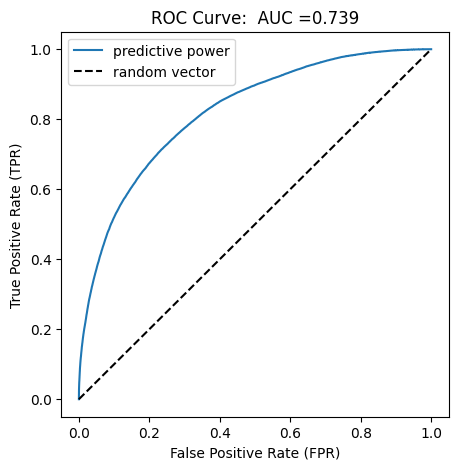

              precision    recall  f1-score   support

           0       0.91      0.74      0.81    154789
           1       0.46      0.74      0.56     46168

    accuracy                           0.74    200957
   macro avg       0.68      0.74      0.69    200957
weighted avg       0.80      0.74      0.75    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,113797,40992
Actual Major_Acc,11865,34303


In [9]:
#check performance on train set !!!
matrix, report = evaluate_classifier(rf_best, X_train, y_train)
matrix

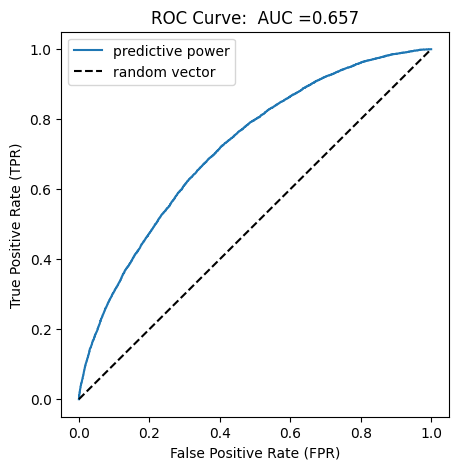

              precision    recall  f1-score   support

           0       0.86      0.70      0.77     27316
           1       0.38      0.62      0.47      8148

    accuracy                           0.68     35464
   macro avg       0.62      0.66      0.62     35464
weighted avg       0.75      0.68      0.70     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,19049,8267
Actual Major_Acc,3128,5020


In [10]:
matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

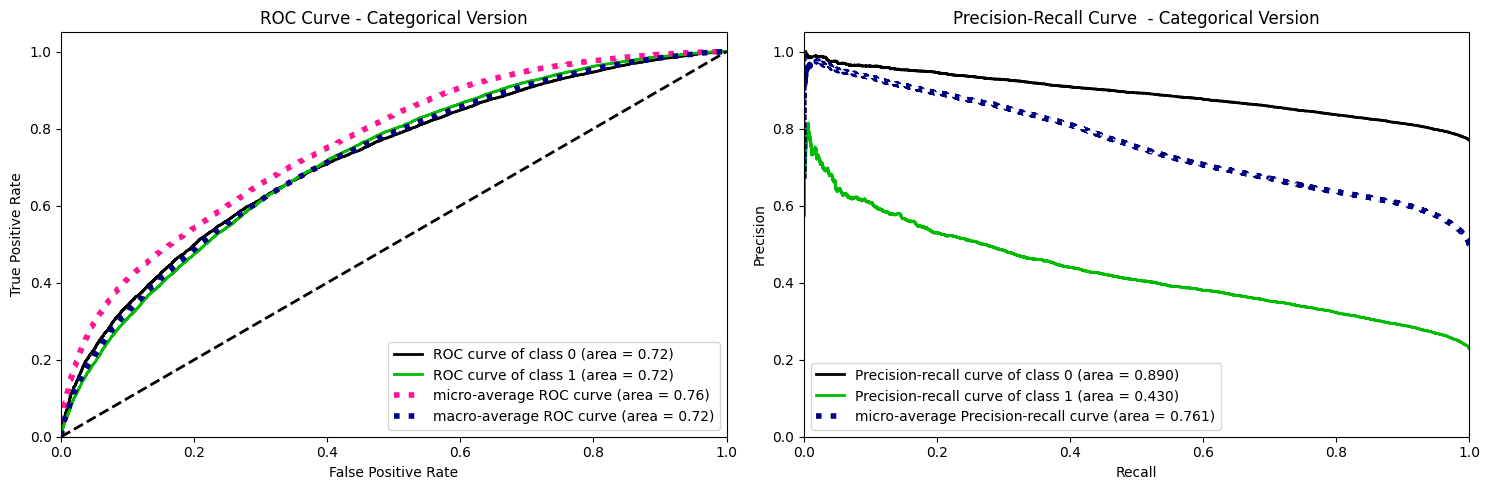

AUC score:  0.7189447313224888         AUPRC score:  0.4300344965014531


(0.7189447313224888, 0.4300344965014531)

In [11]:
ROC_PRC(rf_best, X_test, y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'smallest_veh'),
  Text(1, 0, 'latitude'),
  Text(2, 0, 'longitude'),
  Text(3, 0, 'biggest_vel'),
  Text(4, 0, 'number_of_casualties'),
  Text(5, 0, 'police_force'),
  Text(6, 0, 'number_of_vehicles'),
  Text(7, 0, 'speed_limit'),
  Text(8, 0, 'month'),
  Text(9, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(10, 0, 'urban_or_rural_area'),
  Text(11, 0, 'male_drivers'),
  Text(12, 0, 'time_of_day'),
  Text(13, 0, 'junction_location'),
  Text(14, 0, 'junction_detail'),
  Text(15, 0, 'female_drivers'),
  Text(16, 0, 'road_type'),
  Text(17, 0, 'skidding'),
  Text(18, 0, 'first_road_class'),
  Text(19, 0, 'light_conditions')])

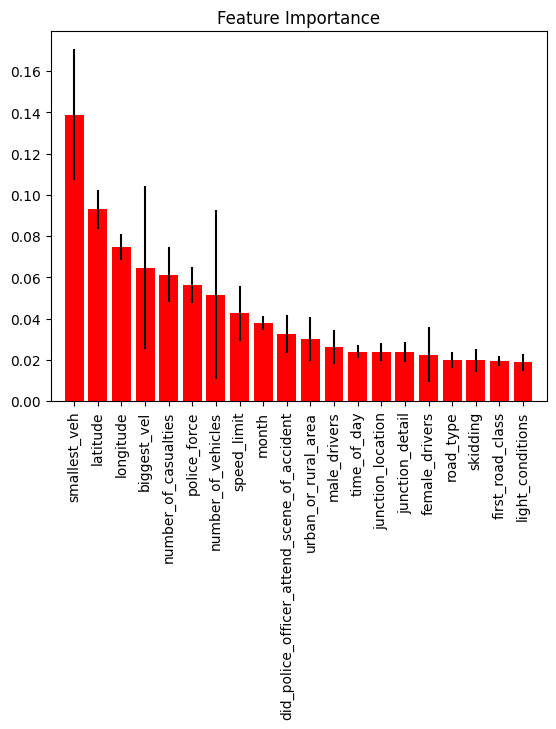

In [12]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

## **Random Forest Classifier with balanced class_weight  RF_CLF:**

parameters_rf = {
    'n_estimators': [200,400],               ------> 200
    'criterion': ["gini"], # "entropy"],
    'max_depth': [12,17],#50],# 12],          ----> 12
    'max_features': ['sqrt'],#'log2']
    'min_samples_leaf': [4,6,8]                ---> 6
}

In [7]:
from imblearn.ensemble import BalancedRandomForestClassifier

#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train
y_train=yc_train
X_test=Xc_val
y_test=yc_val

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label=1)
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [200,400],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [12,17],#50],# 12],
    'max_features': ['sqrt'],#'log2']
    'min_samples_leaf': [4,6,8]

}
rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='f1_score')  #using f1

#rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


rf_best = rf_clf.best_estimator_

It takes 3408.389 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 200}
Hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
   f1_score: 0.468 (+/-0.003)
   precision: 0.364 (+/-0.003)
   recall: 0.653 (+/-0.005)
   accuracy: 0.659 (+/-0.002)
   auc: 0.657 (+/-0.003)
   auprc: 0.318 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
   f1_score: 0.468 (+/-0.003)
   precision: 0.365 (+/-0.003)
   recall: 0.653 (+/-0.005)
   accuracy: 0.659 (+/-0.002)
   auc: 0.657 (+/-0.003)
   auprc: 0.318 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 200}
   f1_score: 0.468 (+/-0.004)
   precision: 0.364 (+/-0.002)
   recall: 0.657 (+/-0.007)
   accuracy: 0.658 (+/-0.002)
   auc: 0.

In [8]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_uc_{timestamp}.pkl"
print(file_name)

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


rf_uc_072222.pkl


In [ ]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = ".pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train
y_train=yc_train
X_test=Xc_val
y_test=yc_val

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    rf_best = pickle.load(file)

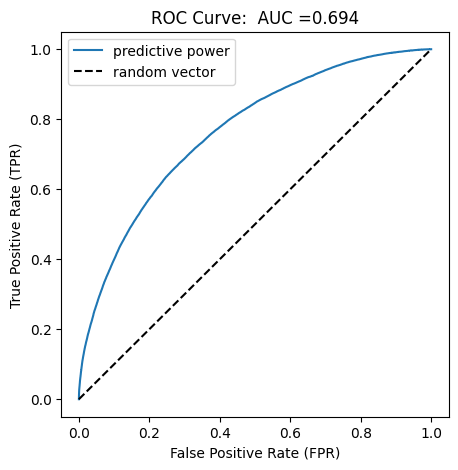

              precision    recall  f1-score   support

           0       0.89      0.67      0.76    154789
           1       0.39      0.72      0.51     46168

    accuracy                           0.68    200957
   macro avg       0.64      0.69      0.64    200957
weighted avg       0.77      0.68      0.71    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,103686,51103
Actual Major_Acc,13043,33125


In [9]:
#check performance on train set !!!
matrix, report = evaluate_classifier(rf_best, X_train, y_train)
matrix

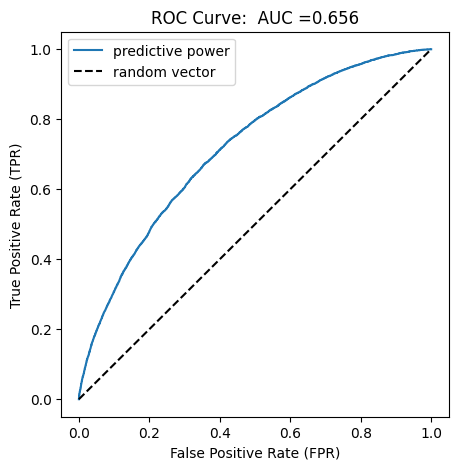

              precision    recall  f1-score   support

           0       0.87      0.65      0.75     27316
           1       0.36      0.66      0.47      8148

    accuracy                           0.66     35464
   macro avg       0.61      0.66      0.61     35464
weighted avg       0.75      0.66      0.68     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,17889,9427
Actual Major_Acc,2790,5358


In [10]:
matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

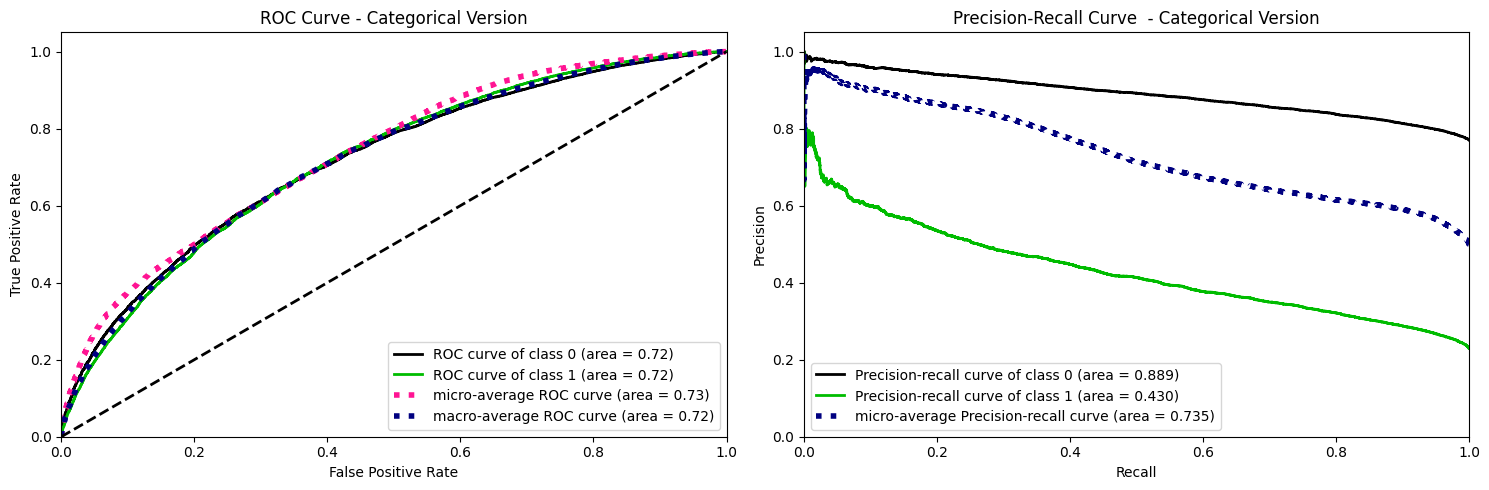

AUC score:  0.7178353897758937         AUPRC score:  0.42997741375935283


(0.7178353897758937, 0.42997741375935283)

In [11]:
ROC_PRC(rf_best, X_test, y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'smallest_veh'),
  Text(1, 0, 'biggest_vel'),
  Text(2, 0, 'number_of_casualties'),
  Text(3, 0, 'latitude'),
  Text(4, 0, 'number_of_vehicles'),
  Text(5, 0, 'speed_limit'),
  Text(6, 0, 'police_force'),
  Text(7, 0, 'longitude'),
  Text(8, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(9, 0, 'urban_or_rural_area'),
  Text(10, 0, 'male_drivers'),
  Text(11, 0, 'female_drivers'),
  Text(12, 0, 'skidding'),
  Text(13, 0, 'month'),
  Text(14, 0, 'road_type'),
  Text(15, 0, 'time_of_day'),
  Text(16, 0, 'junction_detail'),
  Text(17, 0, 'overturned'),
  Text(18, 0, 'light_conditions'),
  Text(19, 0, 'junction_location')])

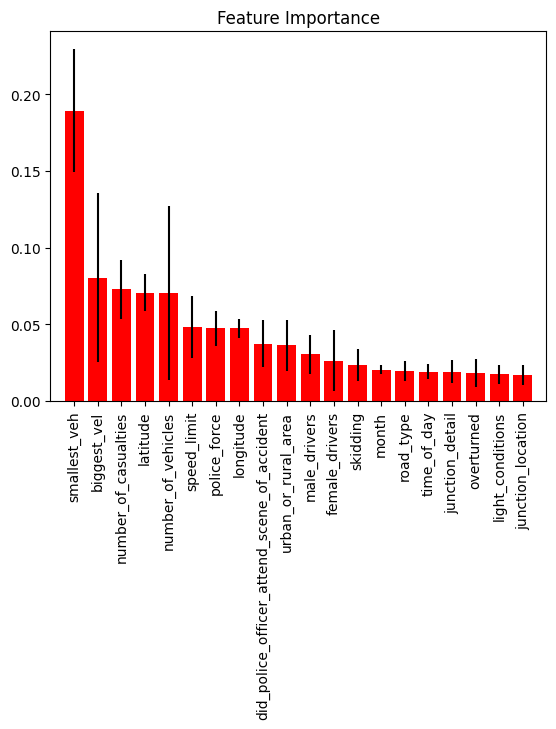

In [12]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

##BalancedRandomForestClassifier

BalancedRandomForestClassifier is another ensemble method in which the tree of the forest will be provided with a balanced bootstrap sample.

In [10]:
from imblearn.ensemble import BalancedRandomForestClassifier

#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train
y_train=yc_train
X_test=Xc_val
y_test=yc_val

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label=1)
scorers = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...

#rf_imbal = RandomForestClassifier(class_weight='balanced')
brf = BalancedRandomForestClassifier(n_estimators=250, criterion='gini', max_depth=11,
                                         min_samples_leaf=6)

parameters_rf = {
    'n_estimators': [250],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [11],#50],# 12],
    'max_features': [int(0.8 * X_train.shape[1]),X_train.shape[1]],#'log2']
    'min_samples_leaf': [6]

}
rf_clf = GridSearchCV(brf, param_grid=parameters_rf, cv=5, scoring=scorers, n_jobs=-1, refit='f1_score')  #using f1

#rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

cv_results = rf_clf.cv_results_

# Print the scores for each hyperparameter combination
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))


brf_best = rf_clf.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

It takes 1279.424 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 11, 'max_features': 36, 'min_samples_leaf': 6, 'n_estimators': 250}
Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 28, 'min_samples_leaf': 6, 'n_estimators': 250}
   f1_score: 0.469 (+/-0.003)
   precision: 0.353 (+/-0.002)
   recall: 0.699 (+/-0.007)
   accuracy: 0.637 (+/-0.003)
   auc: 0.659 (+/-0.003)
   auprc: 0.316 (+/-0.002)
Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 36, 'min_samples_leaf': 6, 'n_estimators': 250}
   f1_score: 0.469 (+/-0.003)
   precision: 0.353 (+/-0.002)
   recall: 0.699 (+/-0.006)
   accuracy: 0.637 (+/-0.002)
   auc: 0.659 (+/-0.003)
   auprc: 0.316 (+/-0.002)


In [11]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"brf_c_{timestamp}.pkl"
print(file_name)

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(brf_best, file)


brf_c_072306.pkl


In [ ]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = "brf_c_072306.pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train
y_train=yc_train
X_test=Xc_val
y_test=yc_val

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    brf_best = pickle.load(file)

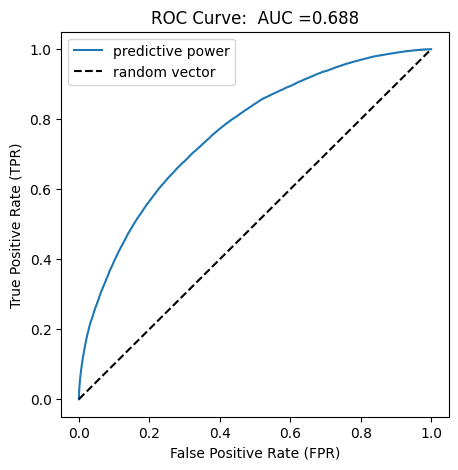

              precision    recall  f1-score   support

           0       0.89      0.63      0.74    154789
           1       0.38      0.74      0.50     46168

    accuracy                           0.66    200957
   macro avg       0.63      0.69      0.62    200957
weighted avg       0.77      0.66      0.69    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,97915,56874
Actual Major_Acc,11827,34341


In [13]:
#check performance on train set !!!
matrix, report = evaluate_classifier(brf_best, X_train, y_train)
matrix

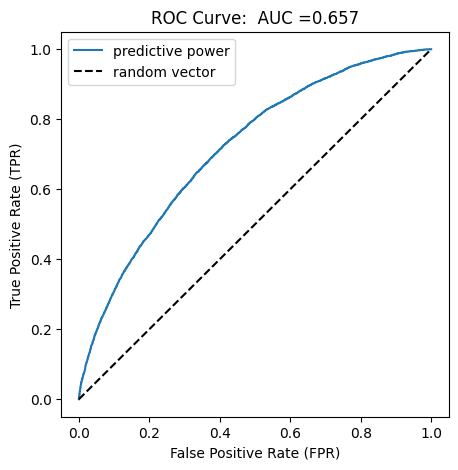

              precision    recall  f1-score   support

           0       0.87      0.62      0.72     27316
           1       0.35      0.69      0.47      8148

    accuracy                           0.64     35464
   macro avg       0.61      0.66      0.60     35464
weighted avg       0.75      0.64      0.67     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,16948,10368
Actual Major_Acc,2504,5644


In [14]:
matrix, report = evaluate_classifier(brf_best, X_test, y_test)
matrix

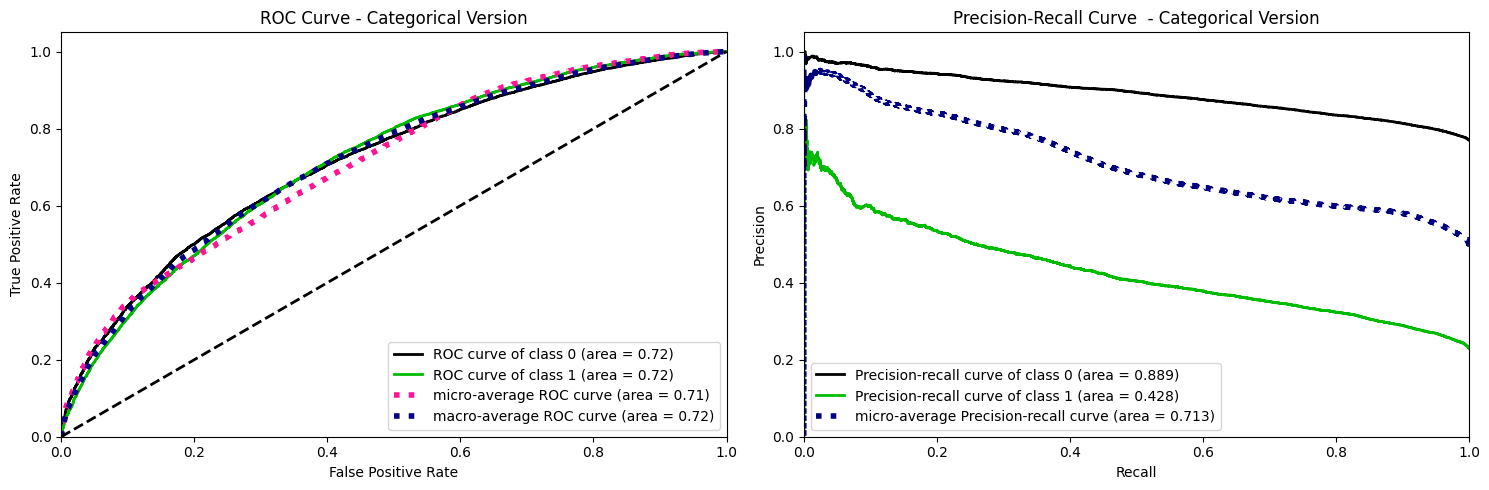

AUC score:  0.7174400885384913         AUPRC score:  0.4282027147179265


(0.7174400885384913, 0.4282027147179265)

In [17]:
ROC_PRC(brf_best, X_test, y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'smallest_veh'),
  Text(1, 0, 'latitude'),
  Text(2, 0, 'number_of_casualties'),
  Text(3, 0, 'biggest_vel'),
  Text(4, 0, 'longitude'),
  Text(5, 0, 'speed_limit'),
  Text(6, 0, 'number_of_vehicles'),
  Text(7, 0, 'urban_or_rural_area'),
  Text(8, 0, 'police_force'),
  Text(9, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(10, 0, 'month'),
  Text(11, 0, 'time_of_day'),
  Text(12, 0, 'male_drivers'),
  Text(13, 0, 'road_type'),
  Text(14, 0, 'light_conditions'),
  Text(15, 0, 'skidding'),
  Text(16, 0, 'junction_detail'),
  Text(17, 0, 'junction_location'),
  Text(18, 0, 'overturned'),
  Text(19, 0, 'first_road_class')])

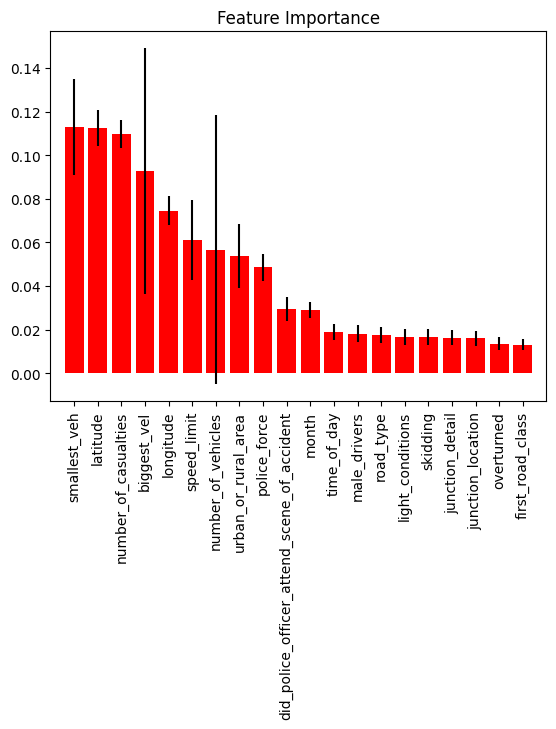

In [18]:
skplt.estimators.plot_feature_importances(brf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

In [24]:
Xe_train

,accident_year,longitude,latitude,number_of_vehicles,number_of_casualties,day_of_week,speed_limit,urban_or_rural_area,did_police_officer_attend_scene_of_accident,hour,...,time_of_day_4,junction_location_0,junction_location_1,junction_location_2,junction_location_3,junction_location_4,junction_location_5,junction_location_6,junction_location_7,junction_location_8
79693,2019,-0.961475,51.465321,3,1,2,30,1,1,8,...,0,0,0,0,0,0,0,0,0,1
305980,2021,-4.468858,55.872561,1,1,7,70,2,0,0,...,1,1,0,0,0,0,0,0,0,0
218270,2021,-0.155093,51.474588,2,1,4,20,1,1,17,...,0,0,0,1,0,0,0,0,0,0
245964,2021,-1.753345,53.788993,3,1,5,30,1,1,15,...,0,0,1,0,0,0,0,0,0,0
252433,2021,-1.292163,54.702980,3,5,6,60,2,0,16,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170536,2020,-0.667071,52.288673,2,1,3,60,2,0,18,...,0,1,0,0,0,0,0,0,0,0
14271,2019,-0.319417,51.561335,2,1,2,30,1,1,12,...,0,1,0,0,0,0,0,0,0,0
265423,2021,-0.049329,53.432040,2,3,1,60,2,0,12,...,0,0,0,0,0,0,0,1,0,0
158507,2020,-2.074058,52.524670,2,1,2,30,1,0,17,...,0,0,0,0,0,0,0,0,0,1


### XGBoost

In [9]:
Xe_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200957 entries, 79693 to 229622
Columns: 172 entries, accident_year to junction_location_8
dtypes: float64(2), int32(1), uint8(169)
memory usage: 37.8 MB


In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(Xe_val.dtypes)

accident_year                                    int32
longitude                                      float64
latitude                                       float64
number_of_vehicles                               uint8
number_of_casualties                             uint8
day_of_week                                      uint8
speed_limit                                      uint8
urban_or_rural_area                              uint8
did_police_officer_attend_scene_of_accident      uint8
hour                                             uint8
weekend                                          uint8
covid                                            uint8
smallest_veh                                     uint8
biggest_vel                                      uint8
towing                                           uint8
restricted                                       uint8
skidding                                         uint8
jacknifed                                        uint8
overturned

In [18]:
# Define dataset as training and validation of undersampling categorical dataframe
X_train = Xe_train
y_train = ye_train
X_test = Xe_val
y_test = ye_val

from sklearn.preprocessing import OneHotEncoder
# One-hot encode categorical features in the training and validation data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)


# Define the F1 score scorer for the 'Major' class
def f1_score_positive(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

scorer = make_scorer(f1_score, pos_label=1)
f1_scorer = make_scorer(f1_score_positive)
scorers = {
    'f1_score': f1_scorer, # make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...



import xgboost as xgb
# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define the parameter grid for hyperparameter tuning
parameters_xgb = {
    'n_estimators': [300],
    'max_depth': [11],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}

# Create the GridSearchCV object
xgb_clf = GridSearchCV(xgb_model, param_grid=parameters_xgb, cv=5, scoring=scorers, refit='f1_score', n_jobs=-1)

t0 = time.time()
xgb_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", xgb_clf.best_params_)

# Get the predicted labels on the validation set
#y_pred_val = cross_val_predict(xgb_clf, X_test, y_test, cv=5)

# Calculate the F1 score for the 'Major' class on the validation set
#f1_score_val = f1_score_positive(y_test, y_pred_val)
print("F1 Score for 'Major' Label on Validation Set:", f1_score_val)

# Print the scores for each hyperparameter combination
cv_results = xgb_clf.cv_results_
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))

xgb_best = xgb_clf.best_estimator_



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


It takes 5361.056 seconds for tuning 
BEST PARAMS {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 300, 'subsample': 0.8}


NameError: ignored

In [20]:

# Print the scores for each hyperparameter combination
cv_results = xgb_clf.cv_results_
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))

xgb_best = xgb_clf.best_estimator_

Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 300, 'subsample': 0.8}
   f1_score: 0.266 (+/-0.006)
   precision: 0.524 (+/-0.009)
   recall: 0.178 (+/-0.005)
   accuracy: 0.774 (+/-0.001)
   auc: 0.565 (+/-0.003)
   auprc: 0.282 (+/-0.003)


In [21]:
xgb_clf.cv_results_

{'mean_fit_time': array([1539.21594343]),
 'std_fit_time': array([285.46270982]),
 'mean_score_time': array([2.35809541]),
 'std_score_time': array([0.72396321]),
 'param_colsample_bytree': masked_array(data=[1.0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[11],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[300],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytree': 1.0,
   'learning_rate': 0.1,
   'max_depth': 11,
   'n_estimators': 300,
   'subsample': 0.8}],
 'split0_test_f1_score': array([0.26399155]),
 'split1_test_f1_score'

In [22]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"xgb_e_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(xgb_best, file)


xgb_e_072401.pkl


In [ ]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = "xgb_e_072401.pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train = Xe_train
y_train = ye_train
X_test = Xe_val
y_test = ye_val


with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    xgb_best = pickle.load(file)

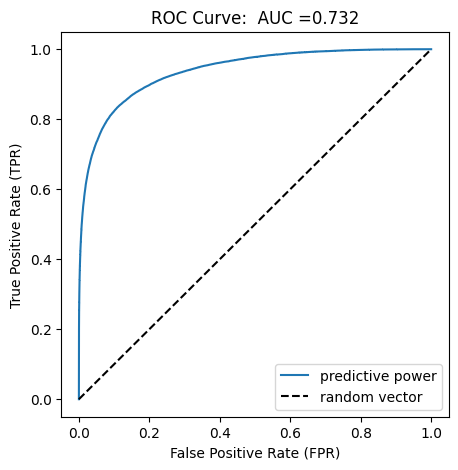

              precision    recall  f1-score   support

           0       0.86      0.99      0.92    154789
           1       0.96      0.47      0.63     46168

    accuracy                           0.87    200957
   macro avg       0.91      0.73      0.78    200957
weighted avg       0.88      0.87      0.86    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,153801,988
Actual Major_Acc,24464,21704


In [23]:
#check performance on train set !!!
matrix, report = evaluate_classifier(xgb_best, X_train, y_train)
matrix

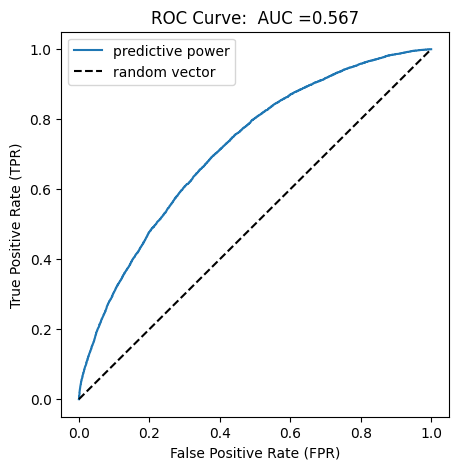

              precision    recall  f1-score   support

           0       0.80      0.95      0.87     27316
           1       0.54      0.18      0.27      8148

    accuracy                           0.78     35464
   macro avg       0.67      0.57      0.57     35464
weighted avg       0.74      0.78      0.73     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,26039,1277
Actual Major_Acc,6673,1475


In [24]:
matrix, report = evaluate_classifier(xgb_best, X_test, y_test)
matrix

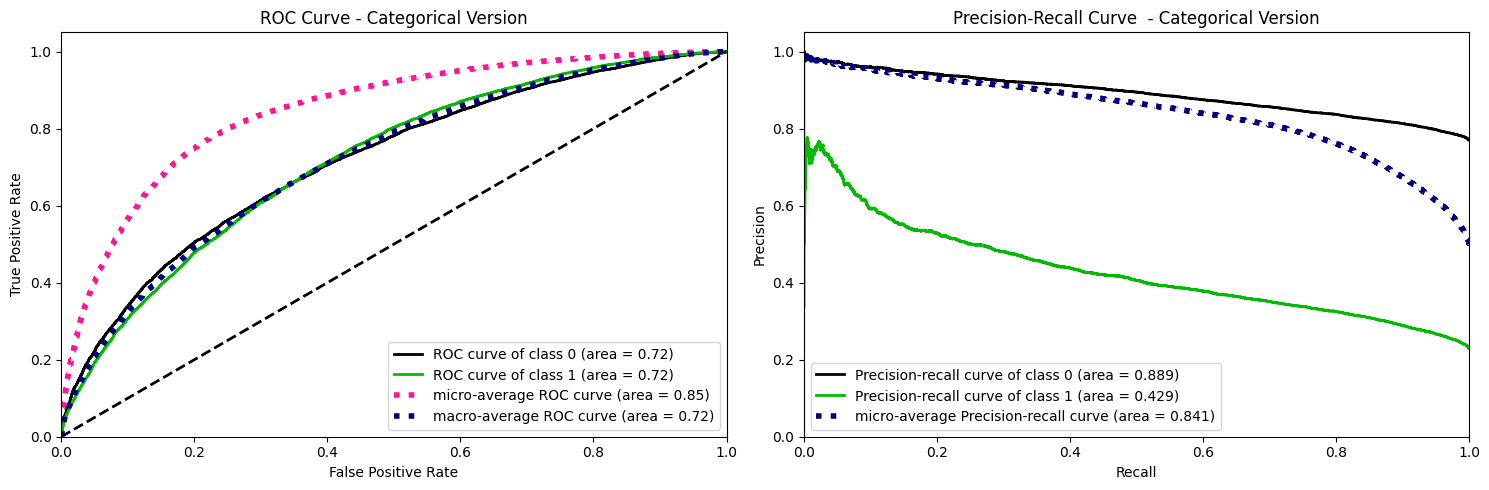

AUC score:  0.7174940354251732         AUPRC score:  0.42872711418555876


(0.7174940354251732, 0.42872711418555876)

In [25]:
ROC_PRC(xgb_best, X_test, y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'smallest_veh'),
  Text(1, 0, 'police_force_52'),
  Text(2, 0, 'police_force_1'),
  Text(3, 0, 'number_of_vehicles'),
  Text(4, 0, 'number_of_casualties'),
  Text(5, 0, 'urban_or_rural_area'),
  Text(6, 0, 'junction_detail_1'),
  Text(7, 0, 'police_force_14'),
  Text(8, 0, 'junction_location_0'),
  Text(9, 0, 'police_force_61'),
  Text(10, 0, 'police_force_7'),
  Text(11, 0, 'police_force_4'),
  Text(12, 0, 'speed_limit'),
  Text(13, 0, 'police_force_53'),
  Text(14, 0, 'police_force_62'),
  Text(15, 0, 'police_force_99'),
  Text(16, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(17, 0, 'biggest_vel'),
  Text(18, 0, 'police_force_12'),
  Text(19, 0, 'police_force_54')])

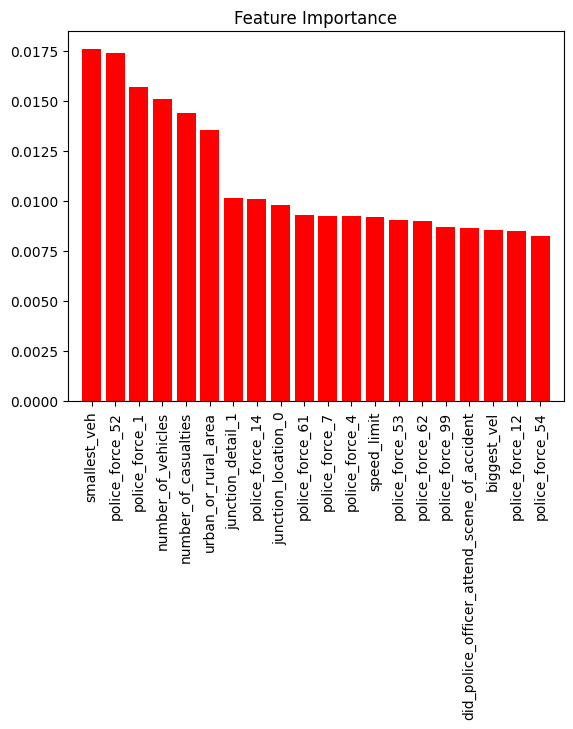

In [26]:
skplt.estimators.plot_feature_importances(xgb_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

XGBoost with Class Weight

In [36]:
# Define dataset as training and validation of undersampling categorical dataframe
X_train = Xe_train
y_train = ye_train
X_test = Xe_val
y_test = ye_val



# Define the F1 score scorer for the 'Major' class
def f1_score_positive(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

scorer = make_scorer(f1_score, pos_label=1)
f1_scorer = make_scorer(f1_score_positive)
scorers = {
    'f1_score': f1_scorer, # make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...
cv1 = StratifiedKFold(n_splits=5, random_state=82, shuffle=True)



import xgboost as xgb
# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define the parameter grid for hyperparameter tuning
parameters_xgb = {
    'n_estimators': [100],
    'max_depth': [9],
    'learning_rate': [0.1],
    'scale_pos_weight': [3.5],
    'subsample': [0.7],
    'colsample_bytree': [.9]
}

# Create the GridSearchCV object
xgb_clf = GridSearchCV(xgb_model, param_grid=parameters_xgb, cv=cv1,
                       scoring=scorers, refit='f1_score', n_jobs=-1, verbose=2)

t0 = time.time()
xgb_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", xgb_clf.best_params_)

# Get the predicted labels on the validation set
#y_pred_val = cross_val_predict(xgb_clf, X_test, y_test, cv=5)

# Calculate the F1 score for the 'Major' class on the validation set
#f1_score_val = f1_score_positive(y_test, y_pred_val)
#print("F1 Score for 'Major' Label on Validation Set:", f1_score_val)

# Print the scores for each hyperparameter combination
cv_results = xgb_clf.cv_results_
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))

xgb_best = xgb_clf.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
It takes 1412.830 seconds for tuning 
BEST PARAMS {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'scale_pos_weight': 3.5, 'subsample': 0.7}


NameError: ignored

In [37]:
cv_results = xgb_clf.cv_results_
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))

xgb_best = xgb_clf.best_estimator_


Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'scale_pos_weight': 3.5, 'subsample': 0.7}
   f1_score: 0.472 (+/-0.003)
   precision: 0.367 (+/-0.002)
   recall: 0.661 (+/-0.006)
   accuracy: 0.660 (+/-0.002)
   auc: 0.661 (+/-0.003)
   auprc: 0.321 (+/-0.002)


In [38]:
xgb_clf.cv_results_

{'mean_fit_time': array([392.38423648]),
 'std_fit_time': array([68.90756561]),
 'mean_score_time': array([0.54850645]),
 'std_score_time': array([0.09816955]),
 'param_colsample_bytree': masked_array(data=[0.9],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[9],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_scale_pos_weight': masked_array(data=[3.5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytree': 0.9,
   'learning_rate': 0.1,
   'max

In [39]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"xgb_e_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(xgb_best, file)


xgb_e_072403.pkl


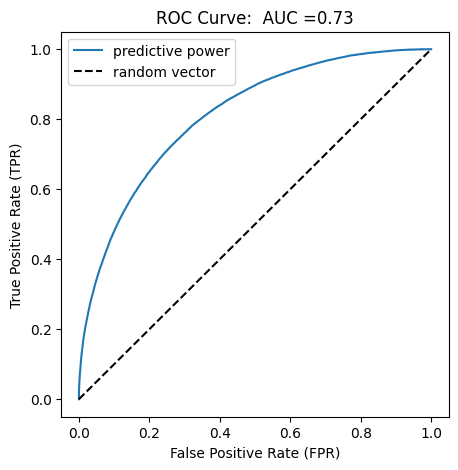

              precision    recall  f1-score   support

           0       0.91      0.69      0.78    154789
           1       0.43      0.77      0.55     46168

    accuracy                           0.71    200957
   macro avg       0.67      0.73      0.67    200957
weighted avg       0.80      0.71      0.73    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,106827,47962
Actual Major_Acc,10601,35567


In [40]:
#check performance on train set !!!
matrix, report = evaluate_classifier(xgb_best, X_train, y_train)
matrix

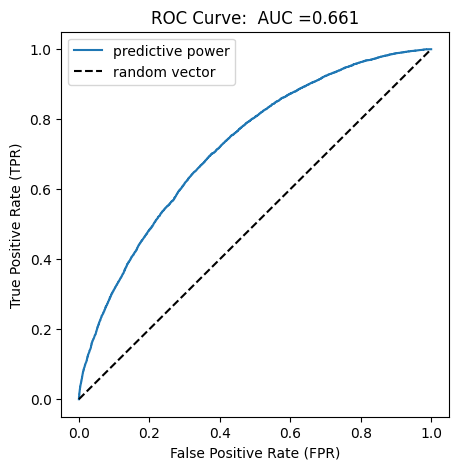

              precision    recall  f1-score   support

           0       0.87      0.66      0.75     27316
           1       0.37      0.67      0.47      8148

    accuracy                           0.66     35464
   macro avg       0.62      0.66      0.61     35464
weighted avg       0.75      0.66      0.68     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,17942,9374
Actual Major_Acc,2729,5419


In [41]:
matrix, report = evaluate_classifier(xgb_best, X_test, y_test)
matrix

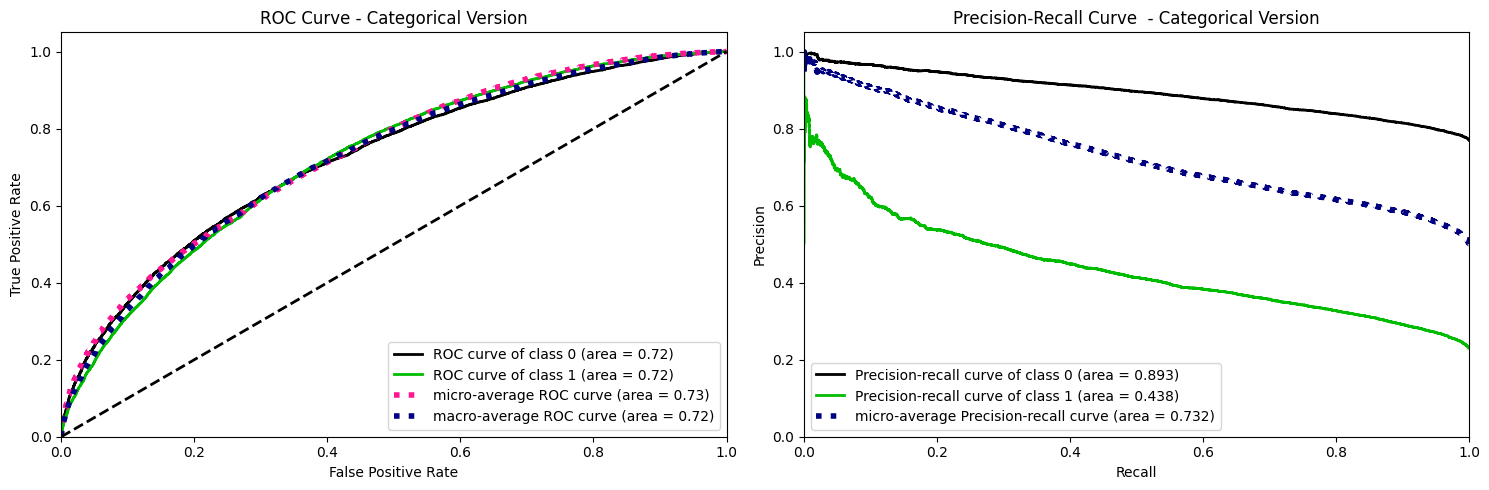

AUC score:  0.7233216762769135         AUPRC score:  0.43813579630120647


(0.7233216762769135, 0.43813579630120647)

In [43]:
ROC_PRC(xgb_best, X_test, y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'smallest_veh'),
  Text(1, 0, 'urban_or_rural_area'),
  Text(2, 0, 'number_of_vehicles'),
  Text(3, 0, 'number_of_casualties'),
  Text(4, 0, 'police_force_1'),
  Text(5, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(6, 0, 'police_force_14'),
  Text(7, 0, 'biggest_vel'),
  Text(8, 0, 'police_force_52'),
  Text(9, 0, 'speed_limit'),
  Text(10, 0, 'police_force_4'),
  Text(11, 0, 'police_force_99'),
  Text(12, 0, 'police_force_53'),
  Text(13, 0, 'trunk_road_flag_3'),
  Text(14, 0, 'junction_detail_1'),
  Text(15, 0, 'overturned'),
  Text(16, 0, 'junction_location_0'),
  Text(17, 0, 'police_force_62'),
  Text(18, 0, 'road_type_6'),
  Text(19, 0, 'police_force_47')])

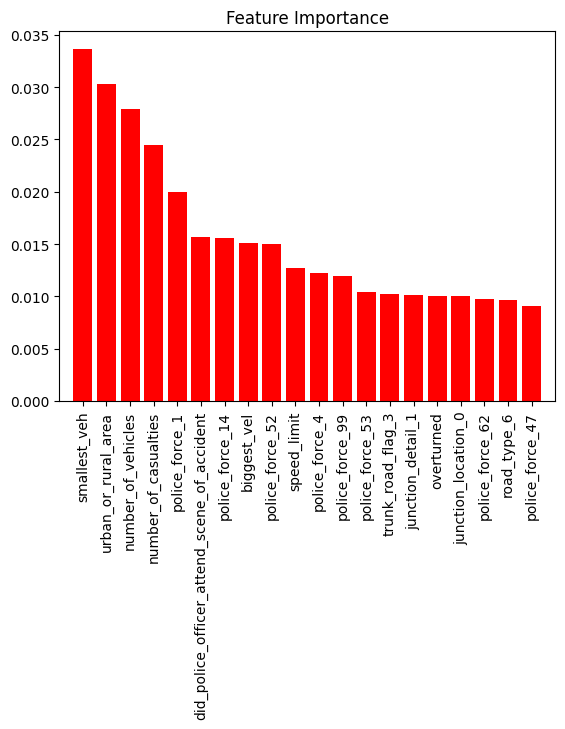

In [42]:
skplt.estimators.plot_feature_importances(xgb_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

Same with more gridsearch to run for a while

In [44]:
# Define dataset as training and validation of undersampling categorical dataframe
X_train = Xe_train
y_train = ye_train
X_test = Xe_val
y_test = ye_val



# Define the F1 score scorer for the 'Major' class
def f1_score_positive(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

scorer = make_scorer(f1_score, pos_label=1)
f1_scorer = make_scorer(f1_score_positive)
scorers = {
    'f1_score': f1_scorer, # make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...
cv1 = StratifiedKFold(n_splits=5, random_state=82, shuffle=True)



import xgboost as xgb
# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define the parameter grid for hyperparameter tuning
parameters_xgb = {
    'n_estimators': [200],
    'max_depth': [8,10],
    'learning_rate': [0.1,0.05],
    'scale_pos_weight': [3.5,4],
    'subsample': [0.7],
    'colsample_bytree': [.9]
}

# Create the GridSearchCV object
xgb_clf = GridSearchCV(xgb_model, param_grid=parameters_xgb, cv=cv1,
                       scoring=scorers, refit='f1_score', n_jobs=-1, verbose=2)

t0 = time.time()
xgb_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", xgb_clf.best_params_)

# Get the predicted labels on the validation set
#y_pred_val = cross_val_predict(xgb_clf, X_test, y_test, cv=5)

# Calculate the F1 score for the 'Major' class on the validation set
#f1_score_val = f1_score_positive(y_test, y_pred_val)
#print("F1 Score for 'Major' Label on Validation Set:", f1_score_val)

# Print the scores for each hyperparameter combination
cv_results = xgb_clf.cv_results_
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))

xgb_best = xgb_clf.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
It takes 17432.452 seconds for tuning 
BEST PARAMS {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': 3.5, 'subsample': 0.7}
Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': 3.5, 'subsample': 0.7}
   f1_score: 0.470 (+/-0.003)
   precision: 0.368 (+/-0.002)
   recall: 0.651 (+/-0.006)
   accuracy: 0.663 (+/-0.001)
   auc: 0.659 (+/-0.003)
   auprc: 0.320 (+/-0.002)
Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': 4, 'subsample': 0.7}
   f1_score: 0.471 (+/-0.003)
   precision: 0.354 (+/-0.002)
   recall: 0.703 (+/-0.006)
   accuracy: 0.637 (+/-0.001)
   auc: 0.660 (+/-0.003)
   auprc: 0.317 (+/-0.002)
Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 3.5, 's

In [45]:
xgb_clf.cv_results_

{'mean_fit_time': array([736.82791519, 740.29685597, 942.45878649, 942.67418346,
        748.91301742, 750.19589095, 956.86774201, 953.82950377]),
 'std_fit_time': array([4.17406234, 4.5836497 , 4.53184839, 6.35582415, 7.79137967,
        3.37770009, 5.3518452 , 0.61376567]),
 'mean_score_time': array([1.02789612, 1.0506218 , 1.25027633, 1.24347234, 0.9621954 ,
        1.12684617, 1.52046919, 1.21068206]),
 'std_score_time': array([0.33604437, 0.36250553, 0.51630603, 0.34283691, 0.27245298,
        0.39584435, 0.49571264, 0.49741629]),
 'param_colsample_bytree': masked_array(data=[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': maske

In [46]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"xgb_e_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(xgb_best, file)


xgb_e_072408.pkl


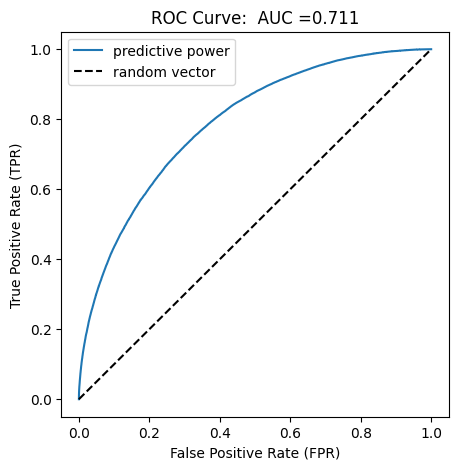

              precision    recall  f1-score   support

           0       0.90      0.67      0.77    154789
           1       0.40      0.76      0.53     46168

    accuracy                           0.69    200957
   macro avg       0.65      0.71      0.65    200957
weighted avg       0.79      0.69      0.71    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,103269,51520
Actual Major_Acc,11292,34876


In [47]:
#check performance on train set !!!
matrix, report = evaluate_classifier(xgb_best, X_train, y_train)
matrix

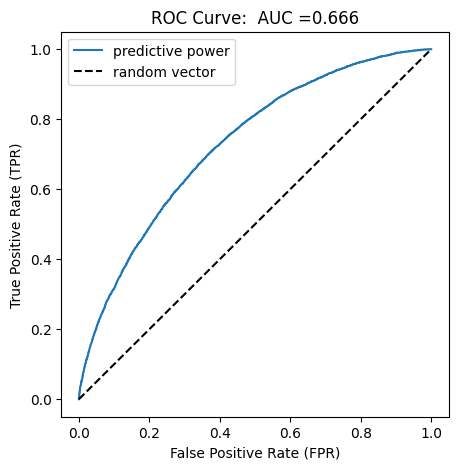

              precision    recall  f1-score   support

           0       0.87      0.65      0.74     27316
           1       0.37      0.68      0.48      8148

    accuracy                           0.66     35464
   macro avg       0.62      0.67      0.61     35464
weighted avg       0.76      0.66      0.68     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,17724,9592
Actual Major_Acc,2589,5559


In [48]:
matrix, report = evaluate_classifier(xgb_best, X_test, y_test)
matrix

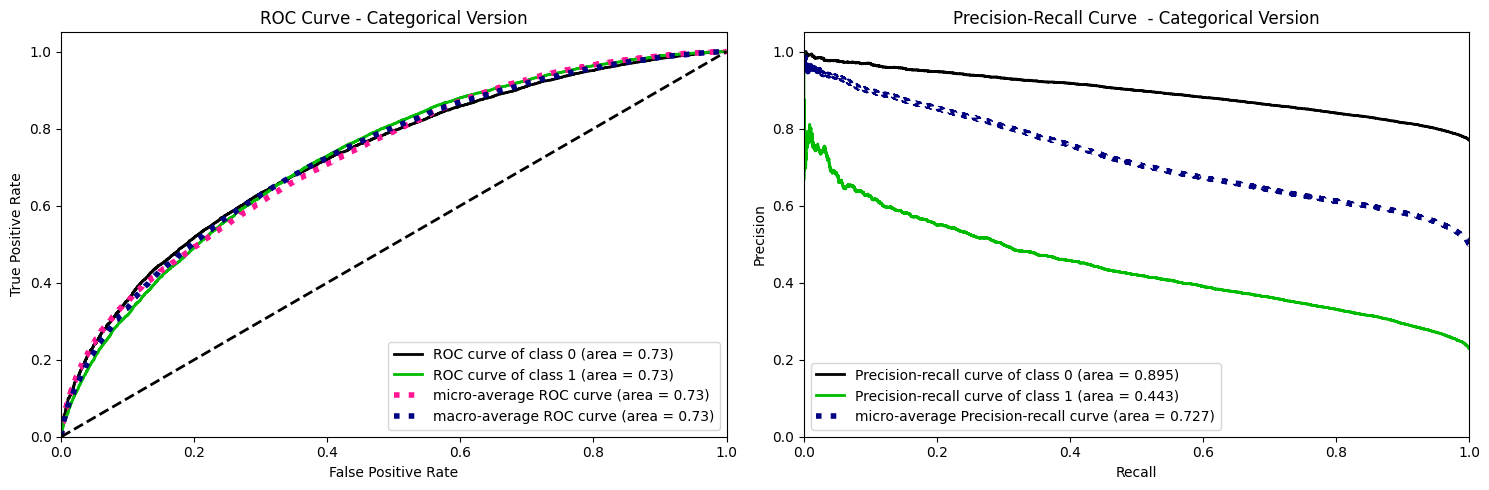

AUC score:  0.7285192905476249         AUPRC score:  0.4427014384122914


(0.7285192905476249, 0.4427014384122914)

In [49]:
ROC_PRC(xgb_best, X_test, y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'number_of_vehicles'),
  Text(1, 0, 'smallest_veh'),
  Text(2, 0, 'urban_or_rural_area'),
  Text(3, 0, 'number_of_casualties'),
  Text(4, 0, 'police_force_1'),
  Text(5, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(6, 0, 'speed_limit'),
  Text(7, 0, 'biggest_vel'),
  Text(8, 0, 'police_force_52'),
  Text(9, 0, 'police_force_14'),
  Text(10, 0, 'police_force_99'),
  Text(11, 0, 'police_force_4'),
  Text(12, 0, 'junction_detail_1'),
  Text(13, 0, 'junction_location_0'),
  Text(14, 0, 'police_force_47'),
  Text(15, 0, 'police_force_62'),
  Text(16, 0, 'trunk_road_flag_3'),
  Text(17, 0, 'police_force_53'),
  Text(18, 0, 'overturned'),
  Text(19, 0, 'light_conditions_6')])

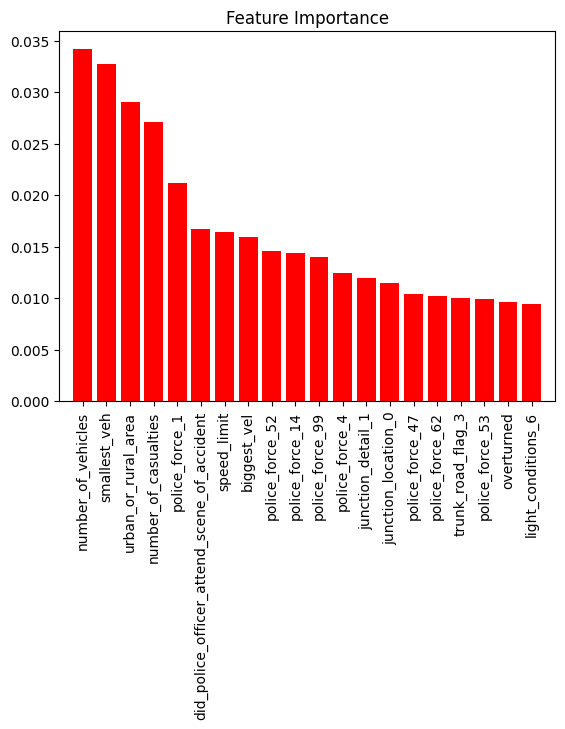

In [50]:
skplt.estimators.plot_feature_importances(xgb_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

## **Naive Base**

In [67]:
from sklearn.naive_bayes import MultinomialNB

# Define dataset as training and validation of undersampling categorical dataframe
X_train = Xc_train
y_train = yc_train
X_test = Xc_val
y_test = yc_val

X_train.longitude += 20
X_test.longitude += 20

#has_negatives = (X_train < 0).any().any()
#print(has_negatives)

# Define the F1 score scorer for the 'Major' class
def f1_score_positive(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

scorer = make_scorer(f1_score, pos_label=1)
f1_scorer = make_scorer(f1_score_positive)
scorers = {
    'f1_score': f1_scorer, # make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}

cv1 = StratifiedKFold(n_splits=10, random_state=82, shuffle=True)

# Create the Multinomial Naive Bayes classifier
class_priors = [0.78, 0.22]

# Create the MultinomialNB classifier with class priors
nb_model = MultinomialNB(class_prior=class_priors, fit_prior=True)
#nb_model = MultinomialNB('class_prior'= [1, 3.5], 'fit_prior'= True)

# Define the parameter grid for hyperparameter tuning
parameters_nb = {
    'alpha': [0.5, 1.0],
}

# Create the GridSearchCV object
nb_clf = GridSearchCV(nb_model, param_grid=parameters_nb, cv=cv1,
                      scoring=scorers, refit='f1_score', n_jobs=-1, verbose=5)

t0 = time.time()
nb_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", nb_clf.best_params_)

# Get the predicted labels on the validation set
#y_pred_val = cross_val_predict(nb_clf, X_test, y_test, cv=5)

# Calculate the F1 score for the 'Major' class on the validation set
#f1_score_val = f1_score_positive(y_test, y_pred_val)
#print("F1 Score for 'Major' Label on Validation Set:", f1_score_val)

# Print the scores for each hyperparameter combination
cv_results = nb_clf.cv_results_
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))

nb_best = nb_clf.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits
It takes 7.080 seconds for tuning 
BEST PARAMS {'alpha': 0.5}
Hyperparameters: {'alpha': 0.5}
   f1_score: 0.320 (+/-0.002)
   precision: 0.278 (+/-0.002)
   recall: 0.375 (+/-0.003)
   accuracy: 0.633 (+/-0.002)
   auc: 0.543 (+/-0.002)
   auprc: 0.248 (+/-0.001)
Hyperparameters: {'alpha': 1.0}
   f1_score: 0.319 (+/-0.002)
   precision: 0.278 (+/-0.002)
   recall: 0.375 (+/-0.003)
   accuracy: 0.633 (+/-0.002)
   auc: 0.542 (+/-0.002)
   auprc: 0.248 (+/-0.001)


False

In [70]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"nb_best{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(nb_best, file)


nb_best072410.pkl


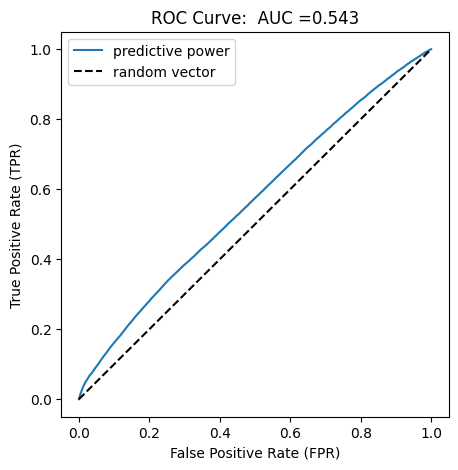

              precision    recall  f1-score   support

           0       0.79      0.71      0.75    154789
           1       0.28      0.38      0.32     46168

    accuracy                           0.63    200957
   macro avg       0.54      0.54      0.53    200957
weighted avg       0.67      0.63      0.65    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,109885,44904
Actual Major_Acc,28838,17330


In [71]:
#check performance on train set !!!
matrix, report = evaluate_classifier(nb_best, X_train, y_train)
matrix

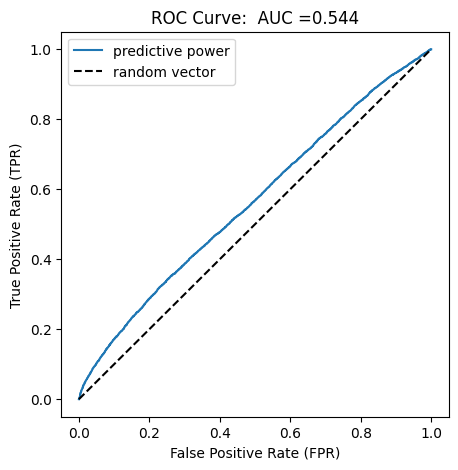

              precision    recall  f1-score   support

           0       0.79      0.71      0.75     27316
           1       0.28      0.38      0.32      8148

    accuracy                           0.63     35464
   macro avg       0.54      0.54      0.53     35464
weighted avg       0.67      0.63      0.65     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,19285,8031
Actual Major_Acc,5042,3106


In [73]:
matrix, report = evaluate_classifier(nb_best, X_test, y_test)
matrix

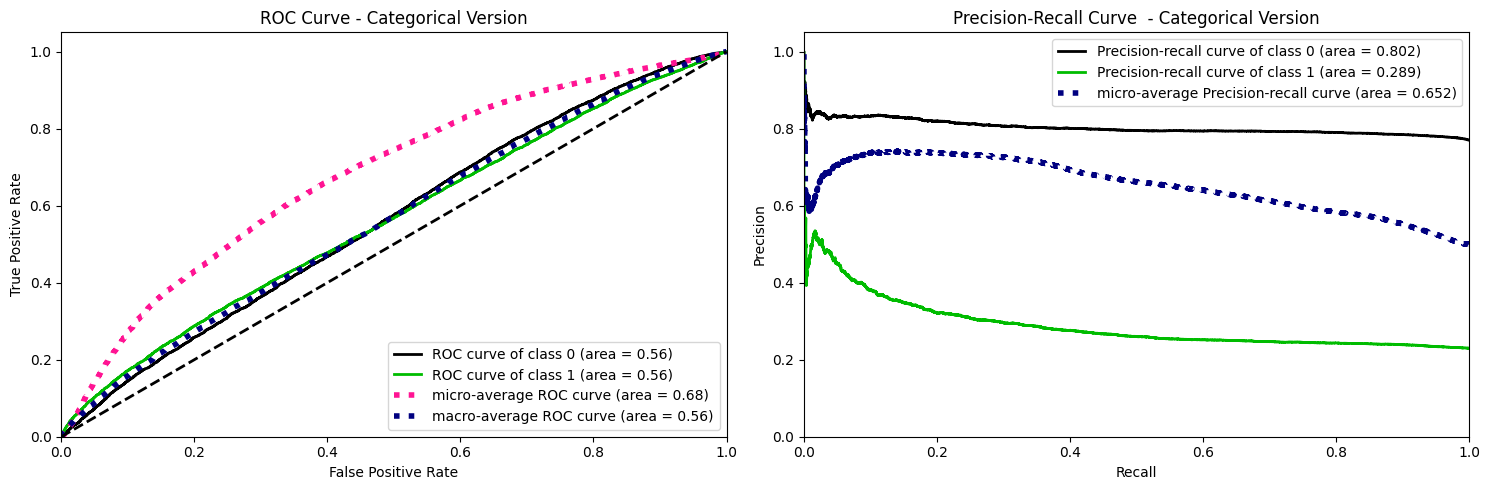

AUC score:  0.5620309896221412         AUPRC score:  0.28883524980832304


(0.5620309896221412, 0.28883524980832304)

In [75]:
ROC_PRC(nb_best, X_test, y_test)

### **Logistic Regression**

In [81]:
from sklearn.linear_model import LogisticRegression


# Define dataset as training and validation of undersampling categorical dataframe
X_train = Xe_train
y_train = ye_train
X_test = Xe_val
y_test = ye_val



# Define the F1 score scorer for the 'Major' class
def f1_score_positive(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

scorer = make_scorer(f1_score, pos_label=1)
f1_scorer = make_scorer(f1_score_positive)
scorers = {
    'f1_score': f1_scorer, # make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score),
}
# ...
cv1 = StratifiedKFold(n_splits=5, random_state=82, shuffle=True)

from sklearn.preprocessing import StandardScaler

# Create the StandardScaler object
scaler = StandardScaler()

# Fit the scaler on X_train and transform X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create the Logistic Regression classifier
lr_model = LogisticRegression()

# Define the parameter grid for hyperparameter tuning
parameters_lr = {
    'penalty': ['l2'],
    'C': [0.1, 1.0, 10.0],
    'class_weight': [{0: 1, 1: 3.5}]#, {0: 1, 1: 4}]
}

# Create the GridSearchCV object
lr_clf = GridSearchCV(lr_model, param_grid=parameters_lr, cv=cv1,
                      scoring=scorers, refit='f1_score', n_jobs=-1, verbose=2)

t0 = time.time()
lr_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", lr_clf.best_params_)

# Print the scores for each hyperparameter combination
cv_results = lr_clf.cv_results_
for i, params in enumerate(cv_results['params']):
    print("Hyperparameters:", params)
    for scorer in scorers:
        score_key = 'mean_test_' + scorer
        std_key = 'std_test_' + scorer
        print("   %s: %.3f (+/-%.3f)" % (scorer, cv_results[score_key][i], cv_results[std_key][i]))

lr_best = lr_clf.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
It takes 194.352 seconds for tuning 
BEST PARAMS {'C': 10.0, 'class_weight': {0: 1, 1: 3.5}, 'penalty': 'l2'}
Hyperparameters: {'C': 0.1, 'class_weight': {0: 1, 1: 3.5}, 'penalty': 'l2'}
   f1_score: 0.423 (+/-0.005)
   precision: 0.315 (+/-0.005)
   recall: 0.645 (+/-0.006)
   accuracy: 0.596 (+/-0.006)
   auc: 0.613 (+/-0.006)
   auprc: 0.285 (+/-0.004)
Hyperparameters: {'C': 1.0, 'class_weight': {0: 1, 1: 3.5}, 'penalty': 'l2'}
   f1_score: 0.425 (+/-0.008)
   precision: 0.317 (+/-0.006)
   recall: 0.645 (+/-0.010)
   accuracy: 0.599 (+/-0.007)
   auc: 0.615 (+/-0.008)
   auprc: 0.286 (+/-0.005)
Hyperparameters: {'C': 10.0, 'class_weight': {0: 1, 1: 3.5}, 'penalty': 'l2'}
   f1_score: 0.428 (+/-0.004)
   precision: 0.317 (+/-0.005)
   recall: 0.657 (+/-0.012)
   accuracy: 0.597 (+/-0.009)
   auc: 0.618 (+/-0.005)
   auprc: 0.287 (+/-0.003)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [82]:
# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"lr_cscaled_{timestamp}.pkl"
print(file_name)
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(lr_best, file)


lr_cscaled_072410.pkl


In [ ]:
# load the model filename=?   # saved model rf_uc_072110.pkl
file_name = ".pkl"
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train_us
y_train=yc_train_us
X_test=Xc_val
y_test=yc_val

with open("./drive/MyDrive/Accidents/Data/"+file_name, 'rb') as file:
    rf_best = pickle.load(file)

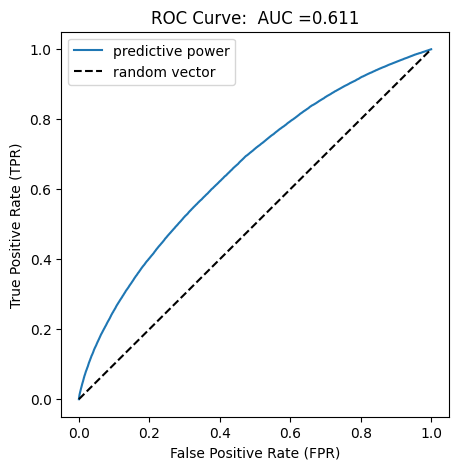

              precision    recall  f1-score   support

           0       0.84      0.58      0.69    154789
           1       0.31      0.64      0.42     46168

    accuracy                           0.59    200957
   macro avg       0.58      0.61      0.55    200957
weighted avg       0.72      0.59      0.63    200957



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,89888,64901
Actual Major_Acc,16570,29598


In [83]:
#check performance on train set !!!
matrix, report = evaluate_classifier(lr_best, X_train, y_train)
matrix

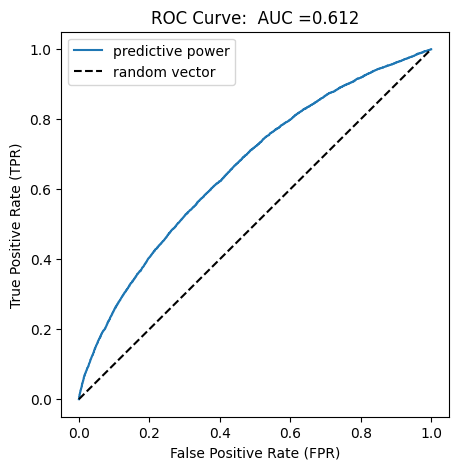

              precision    recall  f1-score   support

           0       0.83      0.68      0.75     27316
           1       0.34      0.54      0.42      8148

    accuracy                           0.65     35464
   macro avg       0.58      0.61      0.58     35464
weighted avg       0.72      0.65      0.67     35464



,predicted \n Minor,predicted \n Major
Actual Minor_Acc,18592,8724
Actual Major_Acc,3725,4423


In [84]:
matrix, report = evaluate_classifier(lr_best, X_test, y_test)
matrix

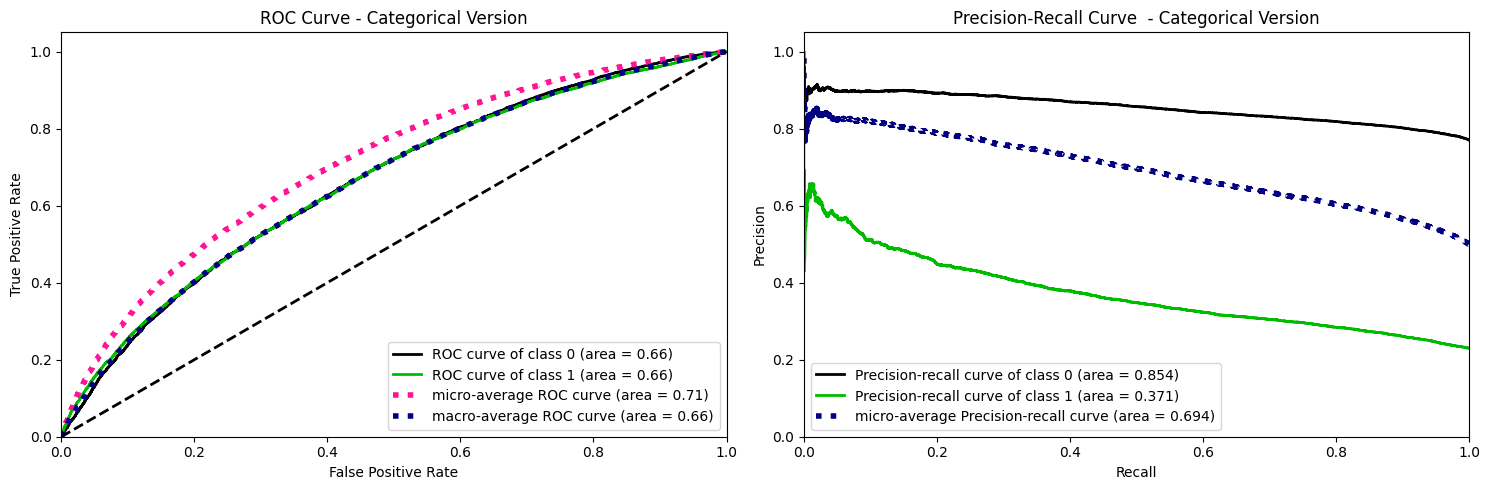

AUC score:  0.6606943010593377         AUPRC score:  0.3706326692056767


(0.6606943010593377, 0.3706326692056767)

In [86]:
ROC_PRC(lr_best, X_test, y_test)